In [1]:
import os
import json
import sys
import numpy as np
import random
from smol.io import load_work
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.inputs import Poscar
from ase.db import connect
from ase.io import write
from ase.visualize import view

sys.path.append('../Modules')
from structure_generation import * 
from vasp_misc import *


# Composition Selection

## functions

In [2]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def load_compositions(json_file):
    """Load compositions from a JSON file."""
    with open(json_file) as f:
        compositions = json.load(f)
    df = pd.DataFrame(compositions)
    if 'Generation' not in df.columns:
        df['Generation'] = 0
    return df

def filter_compositions(df):
    """Filter compositions to ensure they meet the initial constraints."""
    #return df[(df['V'] >= 0.8) & 
    return df[(df['V'] >= 0.20) &
              (df['Cr'] >= 0.001) & 
              (df['Ti'] >= 0.001) & 
              (df['W'] >= 0.001) & 
              (df['Zr'] >= 0.001)]

def generate_random_composition():
    """Generate a valid random composition within the specified constraints."""
    #min_v = 0.85
    min_v = 0.2
    #changed for hea version
    while True:
        V = np.random.uniform(min_v, 1)
        #Cr = np.random.uniform(0.001, 0.2)
        Cr = np.random.uniform(0.01, 0.2)
        #Ti = np.random.uniform(0.001, 0.2)
        Ti = np.random.uniform(0.01, 0.2)
        #W = np.random.uniform(0.001, 0.2)
        W = np.random.uniform(0.01, 0.2)
        #Zr = np.random.uniform(0.001, 0.2)
        Zr = np.random.uniform(0.01, 0.2)
        total = V + Cr + Ti + W + Zr
        V /= total
        Cr /= total
        Ti /= total
        W /= total
        Zr /= total
        if V >= min_v:
            return [V, Cr, Ti, W, Zr]

def generate_new_compositions(n, generation):
    """Generate new compositions and return as a DataFrame."""
    new_compositions = []
    for _ in range(n):
        new_compositions.append(generate_random_composition())
    new_df = pd.DataFrame(new_compositions, columns=['V', 'Cr', 'Ti', 'W', 'Zr'])
    new_df['Generation'] = generation
    return new_df

def combine_compositions(df_existing, df_new):
    """Combine existing and new compositions into one DataFrame."""
    return pd.concat([df_existing, df_new], ignore_index=True)

def save_compositions_to_json(df, json_file):
    """Save compositions to a JSON file."""
    compositions_list = df.to_dict(orient='records')
    with open(json_file, 'w') as f:
        json.dump(compositions_list, f, indent=4)

def plot_compositions(df):
    """Plot compositions using Plotly with manual color assignment for each generation."""
    unique_generations = df['Generation'].unique()
    colors = px.colors.qualitative.Set1 + px.colors.qualitative.Set2 + px.colors.qualitative.Set3
    
    if len(unique_generations) > len(colors):
        raise ValueError("Too many generations for the available color palette")

    color_map = {gen: colors[i] for i, gen in enumerate(sorted(unique_generations))}
    df['color'] = df['Generation'].map(color_map)

    fig = px.scatter_matrix(df,
                            dimensions=['V', 'Cr', 'Ti', 'W', 'Zr'],
                            color='color',
                            title='V-Cr-Ti-W-Zr Alloy Compositions by Generation',
                            labels={'V': 'Vanadium', 'Cr': 'Chromium', 'Ti': 'Titanium', 'W': 'Tungsten', 'Zr': 'Zirconium'},
                            height=800)
    
    # Hide the automatic legend entries
    for trace in fig.data:
        trace.showlegend = False

    # Updating the color legend manually
    for gen, color in color_map.items():
        fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                                 marker=dict(size=10, color=color),
                                 legendgroup=str(gen),
                                 showlegend=True,
                                 name=f'Generation {gen}'))
    
    fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers'))
    fig.show()


/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_97864/3551627776.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## generate compositions and view

In [114]:
random.seed(42)
pre = 3
post = 4
num_compositions = 10
# Example usage
if __name__ == "__main__":
    # Load and filter existing compositions
    df_existing = load_compositions(f'compositions_gen{pre}.json')
    df_existing = filter_compositions(df_existing)
    
    # Generate new compositions for generation 1
    df_new = generate_new_compositions(num_compositions, post)
    
    # Combine existing and new compositions
    df_combined = combine_compositions(df_existing, df_new)
    
    # Save combined compositions to JSON
    save_compositions_to_json(df_combined, f'compositions_gen{post}.json')
    
    # Plot combined compositions
    plot_compositions(df_combined)


/opt/homebrew/Caskroom/miniforge/base/envs/smol/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [3]:
gen_num = 4
json_file = f'../Notebooks/compositions_gen{gen_num}.json'
output_dir = f'../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_{gen_num}/Perfect'

# make the output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



In [4]:
supercells = create_supercells_for_compositions(json_file, output_dir, num_structures=3, lattice_parameter=3.01 , supercell_type='prim')

In [9]:
print(len(supercells))
print(supercells[0])
for supercell in supercells:
    if supercell['generation'] == 4:
        # I also want to print the filename key, but only take the last section split by / 
        filename = supercell['filename'].split('/')[-1]
        # i have a dictionary of composition, that I want to sum over the amounts 
        # i.e supercell['composition'] = {'V': 0.2, 'Cr': 0.2, 'Ti': 0.2, 'W': 0.2, 'Zr': 0.2}, and I'd sum those values
        total = sum(supercell['composition'].values())
        if total != 1:
            print(f"File = {filename}, with Comp = {supercell['composition']}")
            print(f"Total = {total}")
            print("")
        #print(f"File = {filename}, with Comp = {supercell['composition']}")

156
{'filename': '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_4/Perfect/supercell_gen0_comp1_struct1.cif', 'composition': {'Cr': 0.0675, 'Ti': 0.0123, 'Zr': 0.021, 'W': 0.0301, 'V': 0.8691}, 'generation': 0, 'structure': {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[6.02, 6.02, -6.02], [6.02, -6.02, 6.02], [-6.02, 6.02, 6.02]], 'pbc': (True, True, True), 'a': 10.42694586156464, 'b': 10.42694586156464, 'c': 10.42694586156464, 'alpha': 109.47122063449069, 'beta': 109.47122063449069, 'gamma': 109.47122063449069, 'volume': 872.6688319999998}, 'properties': {}, 'sites': [{'species': [{'element': 'Zr', 'occu': 1}], 'abc': [0.0, 0.5, 0.25], 'xyz': [1.505, -1.505, 4.515], 'properties': {}, 'label': 'Zr'}, {'species': [{'element': 'Ti', 'occu': 1}], 'abc': [0.25, 4.619551326923487e-18, 0.0], 'xyz': [1.505, 1.505, -1.505], 'properties': {}, 'label': 'Ti'}, {'species': [{'element': 'V', 'occu': 1}], 'abc': [0.0, 0.0, 0.0], 'xyz

In [11]:
# now if generation = 0, let's make vasp relaxation jobs for all of these structures
# first we will get the list of all the .cif files in the structure output directory

gen_num = 4
cif_files = [f for f in os.listdir(output_dir) if f.endswith('.cif')]

# next select only the structure names that contains gen0
gen0_structures = [f for f in cif_files if f'gen{gen_num}' in f]

# now define vasp_job folder
vasp_job_dir = f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/gen{gen_num}'
# check if the vasp_job_dir exists, if not create it
if not os.path.exists(vasp_job_dir):
    os.makedirs(vasp_job_dir)
kpoints = (6,6,6)
# now we will create the vasp job files for all the gen0 structures
for f in gen0_structures:
    cif_file = os.path.join(output_dir, f)
    struct = Structure.from_file(cif_file)

    # define job path 
    vasp_job_path = os.path.join(vasp_job_dir, f.replace('.cif', ''))

    # make the vasp_job_path directory
    if not os.path.exists(vasp_job_path):
        os.makedirs(vasp_job_path)

    # make a vasp job from the structure
    make_vasp_job(struct, vasp_job_path, kpoints_params=kpoints, vol_relax=True)



# Generate Defects from pristine systems

## defect functions

In [110]:
import os
import json
import sys
import numpy as np
import random
from smol.io import load_work
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.inputs import Poscar
from pymatgen.io.vasp.outputs import Outcar
from ase.db import connect
from ase.io import write
from ase.visualize import view

sys.path.append('../Modules')
from defect_maker import make_defects, return_x_neighbors

# Function to load and sort the structure
def load_and_sort_structure(entry):
    return Structure.from_dict(entry.structure.as_dict()).get_sorted_structure()

def read_contcar_direct(contcar_file):
    try:
        with open(contcar_file, 'r') as file:
            lines = file.readlines()
            # Read the lattice constant
            lattice_constant = float(lines[1].strip())
            # Read the lattice vectors
            lattice_vectors = [list(map(float, line.strip().split())) for line in lines[2:5]]
            # Read the elements and their counts
            #elements = lines[5].strip().split()
            elements = [element.split('_')[0] for element in lines[5].strip().split()]
            print(elements)
            element_counts = list(map(int, lines[6].strip().split()))
            # Create a list of species that matches the number of coordinates
            species = [element for element, count in zip(elements, element_counts) for _ in range(count)]
            # Read the coordinates
            coordinates = [list(map(float, line.strip().split())) for line in lines[8:8+sum(element_counts)]]
            # Convert the coordinates from direct to Cartesian
            cartesian_coordinates = [[sum(a*b for a, b in zip(coord, vector)) for vector in lattice_vectors] for coord in coordinates]
            # Create the structure
            contcar = Structure(lattice_vectors, species, cartesian_coordinates)
            return contcar
    except Exception as e:
        print(f"Error reading CONTCAR file {contcar_file}: {e}")
        raise e
        return None

# Function to find N target atoms without overlapping second nearest neighbors
def _find_target_atoms(structure, N, neighbor_distance=2):
    all_indices = list(range(len(structure)))
    random.shuffle(all_indices)
    target_atoms = []
    neighbor_sets = []

    print(f"All indices: {all_indices}")

    while all_indices and len(target_atoms) < N:
        index = all_indices.pop()
        #neighbors, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=neighbor_distance, alat=structure.lattice.a)
        neighbors = []
        for distance in range(1, neighbor_distance + 1):
            neighbors_distance, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=distance, alat=structure.lattice.a)
            neighbors.extend(neighbors_distance)
        print(f"Index: {index}, Neighbors: {neighbors}")

        if not any(set(neighbors).intersection(neighbor_set) for neighbor_set in neighbor_sets):
            target_atoms.append(index)
            neighbor_sets.append(set(neighbors))
            print(f"Selected target atom index: {index}")

    #return target_atoms if len(target_atoms) == N else None
    return target_atoms 

def find_target_atoms(structure, N, neighbor_distance=2, cutoff_distance=5):
    all_indices = list(range(len(structure)))
    random.shuffle(all_indices)
    target_atoms = []
    neighbor_sets = []

    print(f"All indices: {all_indices}")

    while all_indices and len(target_atoms) < N:
        index = all_indices.pop()
        neighbors = []
        for distance in range(1, neighbor_distance + 1):
            neighbors_distance, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=distance, alat=structure.lattice.a)
            neighbors.extend(neighbors_distance)
        
        print(f"Index: {index}, Neighbors: {neighbors}")

        if not any(set(neighbors).intersection(neighbor_set) for neighbor_set in neighbor_sets):
            # Check if the distance to all existing target atoms is greater than the cutoff distance
            if all(structure.get_distance(index, target_atom) > cutoff_distance for target_atom in target_atoms):
                target_atoms.append(index)
                neighbor_sets.append(set(neighbors))
                print(f"Selected target atom index: {index}")

    #return target_atoms if len(target_atoms) == N else None
    return target_atoms

def _randomly_pick_sites(structure, n):
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure
    random_sites = random.sample(structure.sites, n)
    return random_sites

import random
from scipy.spatial.distance import cdist

def randomly_pick_sites(structure, n, cutoff=1.25):
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure
    random_sites = []
    while len(random_sites) < n:
        potential_site = random.choice(structure.sites)
        if all(cdist([potential_site.coords], [site.coords])[0][0] > cutoff * min(structure.lattice.abc) for site in random_sites):
            random_sites.append(potential_site)
    return random_sites

# Function to select a random neighbor
def select_random_neighbor(structure, target_atom_index, x_neighbor):
    neighbors, _ = return_x_neighbors(structure, target_atom_index, x_neighbor, structure.lattice.a)
    if neighbors:
        return random.choice(neighbors)
    return None

# Function to create and save structures with vacancies
def create_and_save_structures(entries, N, job_path, neighbor_distance=2, cutoff_distance=1.25):
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        #target_atoms = find_target_atoms(structure, N, neighbor_distance, cutoff_distance)
        target_atoms = randomly_pick_sites(structure, N, cutoff = cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue

            for x_neighbor in [1, 2, 3]:
                vac_site = select_random_neighbor(structure, target_atom_index, x_neighbor)
                if vac_site is not None:
                    _, end_structure = make_defects(structure, target_atom_index, vac_site)
                    if end_structure is None:
                        print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                        continue

                    # Create directory and filenames
                    directory = os.path.join(job_path, f"structure_{k}_vac_site_{n}")
                    os.makedirs(directory, exist_ok=True)
                    print(f"Created directory: {directory}")

                    start_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_start.vasp")
                    end_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_end_site_{vac_site}.vasp")

                    # Write the structures to POSCAR files
                    Poscar(start_structure).write_file(start_filename)
                    print(f"Written start structure to {start_filename}")
                    Poscar(end_structure).write_file(end_filename)
                    print(f"Written end structure to {end_filename}")

def create_start_structures(entries, N, job_path, cutoff_distance=1.25):
    start_structures = []
    removed_indexes = []
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        target_atoms = randomly_pick_sites(structure, N, cutoff = cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue
            start_structures.append(start_structure)
            removed_indexes.append(target_atom_index)
    return start_structures, removed_indexes
from pymatgen.entries.computed_entries import ComputedStructureEntry
from monty.json import MontyEncoder, MontyDecoder
from pymatgen.io.vasp import Poscar

def create_start_structures(entries, N, job_path, cutoff_distance=1.25):
    computed_entries = []
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        target_atoms = randomly_pick_sites(structure, N, cutoff = cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            target_atom_index = structure.index(target_atom_index)

            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue

            # Save the structure as a .vasp file
            #start_filename = os.path.join(job_path, f"structure_{k}_vac_site_{n}_start.vasp")
            start_filename = os.path.join(job_path, f"supercell_gen{entry.data['generation']}_comp{entry.data['comp']}_struct{entry.data['struct']}_vac_site{n}_start.vasp")
            Poscar(start_structure).write_file(start_filename)
            print(f"Written start structure to {start_filename}")

            # Create a ComputedStructureEntry and add it to the list
            data = {'generation': entry.data['generation'], 'comp': entry.data['comp'], 'struct': entry.data['struct'], 'perfect_structure' : entry.structure.as_dict()}
            computed_entry = ComputedStructureEntry(start_structure, energy=None, data=data)
            computed_entries.append(computed_entry)

    # Save the computed entries as a JSON file
    with open(os.path.join(job_path, 'computed_entries.json'), 'w') as f:
        json.dump(computed_entries, f, cls=MontyEncoder)

    print("Computed entries saved to JSON file.")

def create_end_structures(start_structures, removed_indexes, job_path):
    for k, (start_structure, target_atom_index) in enumerate(zip(start_structures, removed_indexes)):
        for n, x_neighbor in enumerate([1, 2, 3]):
            vac_site = select_random_neighbor(start_structure, target_atom_index, x_neighbor)
            if vac_site is not None:
                _, end_structure = make_defects(start_structure, target_atom_index, vac_site)
                if end_structure is None:
                    print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                    continue

                # Create directory and filenames
                directory = os.path.join(job_path, f"structure_{k}_vac_site_{n}")
                os.makedirs(directory, exist_ok=True)
                print(f"Created directory: {directory}")

                start_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_start.vasp")
                end_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_end_site_{vac_site}.vasp")

                # Write the structures to POSCAR files
                Poscar(start_structure).write_file(start_filename)
                print(f"Written start structure to {start_filename}")
                Poscar(end_structure).write_file(end_filename)
                print(f"Written end structure to {end_filename}")


## use functions to make defects

Here I need to save all the finished perfect jobs as pymatgen computed structure entries

In [95]:
import os, re
from pymatgen.io.vasp import Poscar, Outcar
from pymatgen.entries.computed_entries import ComputedStructureEntry

# Make entries from existing VASP jobs from Summit
post_vasp_job_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Gen_0-2/Perfect'

# Go through each folder, and create a computed structure entry from the CONTCAR and the OUTCAR files 
entries = []

def extract_numbers(s):
    return list(map(int, re.findall(r'\d+', s)))

for d in os.listdir(post_vasp_job_path):
    dir_path = os.path.join(post_vasp_job_path, d)
    if os.path.isdir(dir_path):
        # Get the CONTCAR and OUTCAR files
        contcar_file = os.path.join(dir_path, 'CONTCAR')
        outcar_file = os.path.join(dir_path, 'OUTCAR')
        
        if os.path.exists(contcar_file) and os.path.exists(outcar_file):
            print(f"Processing directory: {d}")
            if contcar is not None:
                try:
                    contcar = read_contcar_direct(contcar_file)
                except Exception as e:
                    print(f"Error reading CONTCAR file {contcar_file} in directory {d}: {e}")
                    continue
                try:
                    # Read the OUTCAR file
                    outcar = Outcar(outcar_file)
                    print(f"Read OUTCAR from {outcar_file}")
                    # Create the computed structure entry
                    # get the generation number, comp, and struct from the directory name, for example supercell_gen2_comp29_struct1
                    # would be a gen 2, comp 29, struct 1
                    generation, comp, struct = extract_numbers(d)
                    data = {'generation': generation, 'comp': comp, 'struct': struct}
                    entry = ComputedStructureEntry(structure=contcar, energy=outcar.final_energy_wo_entrp, data=data)
                    entries.append(entry)
                    print(f"Successfully created ComputedStructureEntry from {d}")
                except Exception as e:
                    print(f"Error processing OUTCAR file {outcar_file} in directory {d}: {e}")
                    continue
            else:
                print(f"Skipping directory {d} due to missing CONTCAR file.")

print(f"Total entries created: {len(entries)}")


Processing directory: supercell_gen2_comp29_struct1
['Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Gen_0-2/Perfect/supercell_gen2_comp29_struct1/OUTCAR
Successfully created ComputedStructureEntry from supercell_gen2_comp29_struct1
Processing directory: supercell_gen2_comp27_struct2
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Gen_0-2/Perfect/supercell_gen2_comp27_struct2/OUTCAR
Successfully created ComputedStructureEntry from supercell_gen2_comp27_struct2
Processing directory: supercell_gen0_comp7_struct3
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Gen_0-2/Perfect/supercell_gen0_comp7_struct3/OUTCAR
Successfully created ComputedStructureEntry from supercell_gen0_comp7_struct3
Processing directory: supercell_gen1_comp15_struct1
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Visualization/Job_Structures/Post_VASP/VCrTi

In [96]:
# save the entries to the post_vasp_job_path 
with open(os.path.join(post_vasp_job_path, 'entries.json'), 'w') as f:
    json.dump([entry.as_dict() for entry in entries], f)

In [111]:
# Path to save the VASP job structures
vasp_job_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_0-2/Vacancies'
a = 3.01

# check if it exists, if not create it
if not os.path.exists(vasp_job_path):
    os.makedirs(vasp_job_path)

# play around with start and end structures 
# Create and save structures with vacancies
#create_and_save_structures(entries, N=5, job_path=vasp_job_path, neighbor_distance=1, cutoff_distance=1.75)
create_start_structures(entries, N=5, job_path=vasp_job_path, cutoff_distance=1.75)

Processing entry 1/84...
Found target atoms for entry 1: [PeriodicSite: W (-15.81, 54.11, -0.6699) [1.579, 6.386, 2.59], PeriodicSite: V (54.73, 15.06, -1.856) [6.472, 1.776, 2.573], PeriodicSite: V (75.19, -20.01, 12.62) [6.491, -2.363, 2.595], PeriodicSite: Cr (107.1, -63.39, 81.84) [7.186, -7.483, 7.788], PeriodicSite: V (45.54, -9.934, 16.97) [4.061, -1.173, 2.599]]
Written start structure to ../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen2_comp29_struct1_vac_site0_start.vasp
Written start structure to ../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen2_comp29_struct1_vac_site1_start.vasp
Written start structure to ../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen2_comp29_struct1_vac_site2_start.vasp
Written start structure to ../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen2_comp29_struct1_vac_site3_start.vasp
Written start s

Now create vasp vacancy calculation start jobs (isif = 3) from these folders

In [112]:
def _create_vasp_jobs_from_vasp_files(vasp_files_dir, vasp_job_path, kpoints_params, vol_relax=False, incar_params=None):
    for subdir in os.listdir(vasp_files_dir):
        print(f"Processing directory: {subdir}")
        subdir_path = os.path.join(vasp_files_dir, subdir)
        if os.path.isdir(subdir_path):
            print(f"Processing directory: {subdir_path}")
            for filename in os.listdir(subdir_path):
                if filename.endswith('.vasp'):
                    print(f"Processing file: {filename}")
                    filepath = os.path.join(subdir_path, filename)
                    job_name = os.path.splitext(filename)[0]
                    job_folder = os.path.join(vasp_job_path, job_name)
                    os.makedirs(job_folder, exist_ok=True)
                    
                    structure = Poscar.from_file(filepath).structure
                    
                    make_vasp_job(supercell=structure, job_path=job_folder, kpoints_params=kpoints_params, vol_relax=vol_relax, incar_params=incar_params)
                    #make_slurm_file(job_path=job_folder, i=job_name,num_gpus=1,omp_threads=10) # comment out if you are on summit
                    print(f"Created VASP job for {filename} in {job_folder}")

def create_vasp_jobs_from_vasp_files(vasp_files_dir, vasp_job_path, kpoints_params, vol_relax=False, incar_params=None):
    for filename in os.listdir(vasp_files_dir):
        if filename.endswith('.vasp'):
            print(f"Processing file: {filename}")
            filepath = os.path.join(vasp_files_dir, filename)
            job_name = os.path.splitext(filename)[0]
            job_folder = os.path.join(vasp_job_path, job_name)
            os.makedirs(job_folder, exist_ok=True)
            
            structure = Poscar.from_file(filepath).structure
            
            make_vasp_job(supercell=structure, job_path=job_folder, kpoints_params=kpoints_params, vol_relax=vol_relax, incar_params=incar_params)
            #make_slurm_file(job_path=job_folder, i=job_name,num_gpus=1,omp_threads=10) # comment out if you are on summit
            print(f"Created VASP job for {filename} in {job_folder}")

# Directory containing the .vasp files in subdirectories
vasp_files_dir = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/Gen_0-2/Vacancies'
vasp_job_path = '../Archived_Vasp_Jobs/VCrTiWZr_Summit/Gen_0-2/Vacancies'
# check if vasp_job_path exists, if not create it
if not os.path.exists(vasp_job_path):
    os.makedirs(vasp_job_path)
kpoints_params = (6, 6, 6)

# Create VASP jobs from .vasp files in subdirectories
create_vasp_jobs_from_vasp_files(vasp_files_dir, vasp_job_path, kpoints_params, vol_relax=True) # change vol_relax to True for start points 

Processing file: supercell_gen1_comp17_struct2_vac_site4_start.vasp
Created VASP job for supercell_gen1_comp17_struct2_vac_site4_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen1_comp17_struct2_vac_site4_start
Processing file: supercell_gen2_comp27_struct3_vac_site0_start.vasp
Created VASP job for supercell_gen2_comp27_struct3_vac_site0_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen2_comp27_struct3_vac_site0_start
Processing file: supercell_gen2_comp28_struct3_vac_site3_start.vasp
Created VASP job for supercell_gen2_comp28_struct3_vac_site3_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen2_comp28_struct3_vac_site3_start
Processing file: supercell_gen0_comp1_struct3_vac_site2_start.vasp
Created VASP job for supercell_gen0_comp1_struct3_vac_site2_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Gen_0-2/Vacancies/supercell_gen0_comp1_struct3_vac_site2_start
Processing file: superc

In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site

import plotly.graph_objects as go
from pymatgen.core.structure import Structure
import numpy as np
import itertools
from collections import defaultdict

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    geometric_dist = site1.distance(site2)
    composition_dist = sum((site1.species.elements[i].X - site2.species.elements[i].X)**2 for i in range(len(site1.species.elements)))
    return geometric_dist + composition_dist

def objective(points, distance_matrix):
    total_dist = 0
    for i, p1 in enumerate(points):
        for j, p2 in enumerate(points):
            if i < j:
                total_dist += 1 / distance_matrix[i][j]
    return total_dist

def simulated_annealing_sampling(structure, num_points, initial_temp=1000, cooling_rate=0.9):
    sites = structure.sites
    points = random.sample(sites, num_points)
    
    # Precompute distance matrix using custom distance
    distance_matrix = np.zeros((len(sites), len(sites)))
    for i, site1 in enumerate(sites):
        for j, site2 in enumerate(sites):
            distance_matrix[i][j] = custom_distance(site1, site2)
    
    temp = initial_temp
    while temp > 1:
        new_points = points[:]
        i = random.randint(0, num_points - 1)
        new_points[i] = random.choice(sites)
        
        current_energy = objective(points, distance_matrix)
        new_energy = objective(new_points, distance_matrix)
        
        if new_energy < current_energy or random.uniform(0, 1) < np.exp((current_energy - new_energy) / temp):
            points = new_points
        
        temp *= cooling_rate
    
    return points

def plot_distance_matrix(structure):
    sites = structure.sites
    distance_matrix = np.zeros((len(sites), len(sites)))
    for i, site1 in enumerate(sites):
        for j, site2 in enumerate(sites):
            distance_matrix[i][j] = custom_distance(site1, site2)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, cmap="viridis")
    plt.title("Custom Distance Matrix Heatmap")
    plt.xlabel("Site Index")
    plt.ylabel("Site Index")
    plt.show()

def identify_highest_complexity_sites(structure, top_n=3):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[-top_n:][::-1]
    return [sites[i] for i in top_indices]

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()



Selected Sites for Simulated Annealing Sampling:
[array([-1.22731987,  2.13240275,  4.3409668 ]), array([-2.46668049,  8.41368559,  3.47665283]), array([3.69850197, 2.06051816, 5.23781301]), array([3.62635623, 2.07059798, 7.85884545]), array([ 4.96987084,  8.45496349, -4.37867878])]


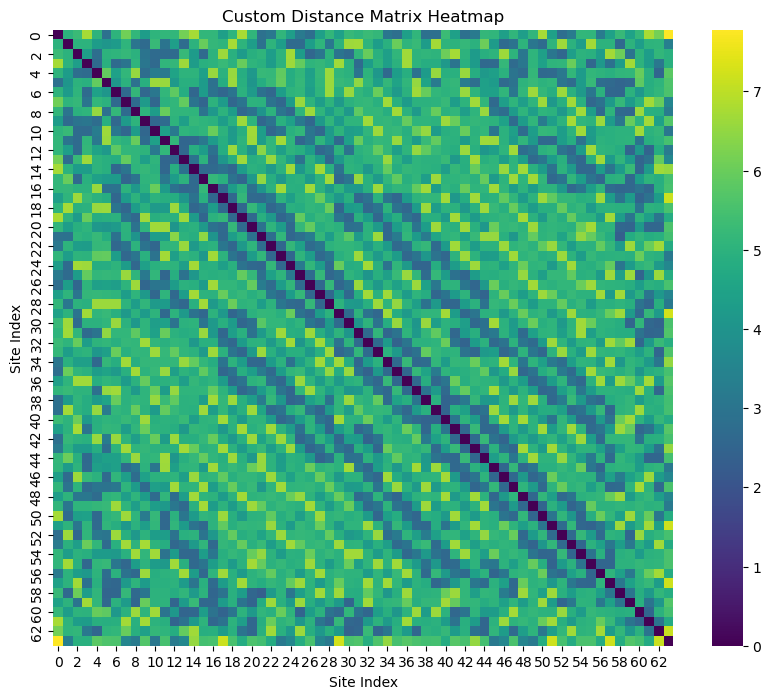

Sites with Highest Chemical Complexity:
[(PeriodicSite: W (-1.227, 2.132, 4.341) [0.002078, 0.2515, 0.4994], array([-1.22731987,  2.13240275,  4.3409668 ])), (PeriodicSite: Zr (2.467, 4.19, -0.8905) [0.4971, 0.4942, 0.2457], array([ 2.46749269,  4.19013878, -0.89047959])), (PeriodicSite: V (-1.18, 2.128, -0.79) [0.005885, 0.2509, 0.009978], array([-1.17968787,  2.12835832, -0.79002516]))]


In [43]:
contcar_file = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Gen_0-2/Perfect/supercell_gen0_comp10_struct1/CONTCAR'
# Example usage:
structure = Poscar.from_file(contcar_file).structure # Load your structure here

# Simulated Annealing Sampling
selected_sites = simulated_annealing_sampling(structure, num_points=5)
print("Selected Sites for Simulated Annealing Sampling:")
print([site.coords for site in selected_sites])

# Plot Distance Matrix
plot_distance_matrix(structure)

# Identify Highest Complexity Sites
top_sites = identify_highest_complexity_sites(structure)
print("Sites with Highest Chemical Complexity:")
print([(site, site.coords) for site in top_sites])


In [44]:
def identify_highest_complexity_sites(structure, top_n=3):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[-top_n:][::-1]
    return [sites[i] for i in top_indices]

# Example usage:
top_sites = identify_highest_complexity_sites(structure)
print("Sites with Highest Chemical Complexity:")
for site in top_sites:
    print(f"Index: {structure.index(site)}, Coordinates: {site.coords}")


Sites with Highest Chemical Complexity:
Index: 63, Coordinates: [-1.22731987  2.13240275  4.3409668 ]
Index: 0, Coordinates: [ 2.46749269  4.19013878 -0.89047959]
Index: 9, Coordinates: [-1.17968787  2.12835832 -0.79002516]


In [45]:
plot_structure_with_highlighted_sites(structure, top_sites)


In [49]:
import numpy as np
import random
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    geometric_dist = site1.distance(site2)
    composition_dist = sum((site1.species.elements[i].X - site2.species.elements[i].X)**2 for i in range(len(site1.species.elements)))
    return geometric_dist + composition_dist

def identify_highest_complexity_sites(structure, top_n=3, concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    selected_sites = []
    for index in top_indices:
        if len(selected_sites) >= top_n:
            break
        site = sites[index]
        element = str(site.species)
        if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
            selected_sites.append(site)
            element_counts[element] -= 1
        else:
            # Find a nearby site with comparable complexity and an element with more than 2 in the structure
            min_dist = float('inf')
            best_site = None
            for other_site in sites:
                other_element = str(other_site.species)
                if other_site not in selected_sites and element_counts[other_element] > 2:
                    dist = site.distance(other_site)
                    if dist < min_dist and complexity_scores[sites.index(other_site)] >= complexity_scores[index] * 0.9:
                        min_dist = dist
                        best_site = other_site
            if best_site:
                selected_sites.append(best_site)
                element_counts[str(best_site.species)] -= 1

    return selected_sites

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure,top_n=5)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [57]:
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools
from pymatgen.analysis.local_env import VoronoiNN

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    geometric_dist = site1.distance(site2)
    composition_dist = sum((site1.species.elements[i].X - site2.species.elements[i].X)**2 for i in range(len(site1.species.elements)))
    return geometric_dist + composition_dist

def identify_highest_complexity_sites(structure, top_n=3, concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    vnn = VoronoiNN()
    selected_sites = []
    selected_neighbors = set()

    for index in top_indices:
        if len(selected_sites) >= top_n:
            break
        site = sites[index]
        element = str(site.species)

        if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
            neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))

            if not selected_neighbors.intersection(neighbors):
                selected_sites.append(site)
                selected_neighbors.update(neighbors)
                element_counts[element] -= 1
        else:
            # Find a nearby site with comparable complexity and an element with more than 2 in the structure
            min_dist = float('inf')
            best_site = None
            best_index = None
            for other_index, other_site in enumerate(sites):
                other_element = str(other_site.species)
                if other_site not in selected_sites and element_counts[other_element] > 2:
                    dist = site.distance(other_site)
                    if dist < min_dist and complexity_scores[other_index] >= complexity_scores[index] * 0.9:
                        neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, other_index))
                        if not selected_neighbors.intersection(neighbors):
                            min_dist = dist
                            best_site = other_site
                            best_index = other_index
            if best_site:
                selected_sites.append(best_site)
                selected_neighbors.update(neighbors)
                element_counts[str(best_site.species)] -= 1

    return selected_sites

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure, top_n=5, concentration_threshold=0.2)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [56]:
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools
from pymatgen.analysis.local_env import VoronoiNN

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    # Geometric distance
    geometric_dist = site1.distance(site2)
    
    # Chemical composition distance (difference in electronegativity)
    element1 = list(site1.species.elements)[0]
    element2 = list(site2.species.elements)[0]
    composition_dist = (element1.X - element2.X) ** 2
    
    # Debugging print statements
    #print(f"Geometric distance between {element1} and {element2}: {geometric_dist}")
    #print(f"Electronegativity difference squared: {composition_dist}")
    
    # Combined distance
    combined_dist = geometric_dist + composition_dist
    #print(f"Combined distance: {combined_dist}\n")
    
    return combined_dist

def identify_highest_complexity_sites(structure, top_n=3, initial_concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    vnn = VoronoiNN()
    selected_sites = []
    selected_neighbors = set()
    
    concentration_threshold = initial_concentration_threshold
    while len(selected_sites) < top_n and concentration_threshold <= 1.0:
        for index in top_indices:
            if len(selected_sites) >= top_n:
                break
            site = sites[index]
            element = str(site.species)

            if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
                neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))

                if not selected_neighbors.intersection(neighbors):
                    selected_sites.append(site)
                    selected_neighbors.update(neighbors)
                    element_counts[element] -= 1
            else:
                # Find a nearby site with comparable complexity and an element with more than 2 in the structure
                min_dist = float('inf')
                best_site = None
                best_index = None
                for other_index, other_site in enumerate(sites):
                    other_element = str(other_site.species)
                    if other_site not in selected_sites and element_counts[other_element] > 2:
                        dist = site.distance(other_site)
                        if dist < min_dist and complexity_scores[other_index] >= complexity_scores[index] * 0.9:
                            neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, other_index))
                            if not selected_neighbors.intersection(neighbors):
                                min_dist = dist
                                best_site = other_site
                                best_index = other_index
                if best_site:
                    selected_sites.append(best_site)
                    selected_neighbors.update(neighbors)
                    element_counts[str(best_site.species)] -= 1
        
        # If not enough sites found, relax the concentration threshold
        if len(selected_sites) < top_n:
            concentration_threshold += 0.1
    
    return selected_sites[:top_n]

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [61]:
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools
from pymatgen.analysis.local_env import VoronoiNN
import random

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    # Geometric distance
    geometric_dist = site1.distance(site2)
    
    # Chemical composition distance (difference in electronegativity)
    element1 = list(site1.species.elements)[0]
    element2 = list(site2.species.elements)[0]
    composition_dist = (element1.X - element2.X) ** 2
    
    # Debugging print statements
    #print(f"Geometric distance between {element1} and {element2}: {geometric_dist}")
    #print(f"Electronegativity difference squared: {composition_dist}")
    
    # Combined distance
    combined_dist = geometric_dist + composition_dist
    #print(f"Combined distance: {combined_dist}\n")
    
    return combined_dist

def identify_highest_complexity_sites(structure, top_n=3, concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    vnn = VoronoiNN()
    selected_sites = []
    selected_neighbors = set()

    for index in top_indices:
        if len(selected_sites) >= top_n:
            break
        site = sites[index]
        element = str(site.species)

        if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
            neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))

            if not selected_neighbors.intersection(neighbors):
                selected_sites.append(site)
                selected_neighbors.update(neighbors)
                element_counts[element] -= 1
        else:
            # Find a nearby site with comparable complexity and an element with more than 2 in the structure
            min_dist = float('inf')
            best_site = None
            best_index = None
            for other_index, other_site in enumerate(sites):
                other_element = str(other_site.species)
                if other_site not in selected_sites and element_counts[other_element] > 2:
                    dist = site.distance(other_site)
                    if dist < min_dist and complexity_scores[other_index] >= complexity_scores[index] * 0.9:
                        neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, other_index))
                        if not selected_neighbors.intersection(neighbors):
                            min_dist = dist
                            best_site = other_site
                            best_index = other_index
            if best_site:
                selected_sites.append(best_site)
                selected_neighbors.update(neighbors)
                element_counts[str(best_site.species)] -= 1

    # If we don't have enough sites, add more based on distance
    while len(selected_sites) < top_n:
        for _ in range(top_n - len(selected_sites)):
            for index in range(len(sites)):
                if sites[index] not in selected_sites:
                    neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))
                    if not selected_neighbors.intersection(neighbors):
                        selected_sites.append(sites[index])
                        selected_neighbors.update(neighbors)
                        break

    return selected_sites

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

import random
from pymatgen.core.structure import Structure

def randomly_pick_sites(structure, n):
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure
    random_sites = random.sample(structure.sites, n)
    return random_sites

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Randomly pick 5 sites from the supercell

# Print the coordinates of the randomly selected sites
#for site in random_sites:
    #print(f"Element: {site.species}, Coordinates: {site.coords}")

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure, top_n=5, concentration_threshold=0.2)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [92]:
random_sites = randomly_pick_sites(structure, n=8)
plot_structure_with_highlighted_sites(structure, random_sites)